# Setup

In [1]:
!pip install -q tf-models-official==2.3.0
!pip install transformers

In [2]:
import os
import json, pickle

import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split

import transformers
from transformers import BertTokenizer, TFBertModel
transformers.logging.set_verbosity_error() # suppress tokenizer sentences' length warnings so to not disturbate rou beautiful loading bar oh my gosh

from keras import Model
from keras.utils import plot_model
from keras.layers import Input, Dense

This directory contains the configuration, vocabulary, and a pre-trained checkpoint used in this tutorial:

In [3]:
# import sys
# !git clone "https://github.com/giuliofortini/NLP_SQuAD_Project"
# sys.path.append("NLP_SQuAD_Project/")

from google.colab import files
try:
  with open('training_set.json') as f:
    json_data = json.load(f)
except:
  from google.colab import drive
  drive.mount('/content/drive')
  with open('/content/drive/My Drive/SQUAD/training_set.json') as f:
    json_data = json.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Hyperparameters


In [16]:
# hyperparams
SEQUENCE_LIMIT = 512
STRIDE = 256

TRAIN_LIMIT = 6000
TEST_LIMIT = 1000

RANDOM_STATE = 42

# <s> Dataset </s>

In [5]:
data = pd.json_normalize(json_data['data'])
data

title                                         paragraphs
0    University_of_Notre_Dame  [{'context': 'Architecturally, the school has ...
1                     Beyoncé  [{'context': 'Beyoncé Giselle Knowles-Carter (...
2                     Montana  [{'context': 'Montana i/mɒnˈtænə/ is a state i...
3                    Genocide  [{'context': 'The phrase "in whole or in part"...
4                 Antibiotics  [{'context': 'The emergence of resistance of b...
..                        ...                                                ...
437                    Police  [{'context': 'A police force is a constituted ...
438          Punjab,_Pakistan  [{'context': 'Punjab (Urdu, Punjabi: پنجاب, pa...
439                 Infection  [{'context': ' Among the vast varieties of mic...
440                   Hunting  [{'context': 'Hunting is the practice of killi...
441                 Kathmandu  [{'context': 'Kathmandu(/ˌkɑːtmɑːnˈduː/; Nepal...

[442 rows x 2 columns]

In [7]:
def preprocess_df(df):
  temp = []
  title_dict = {}
  contexts = []

  for i, row in df.iterrows():
    for context in row['paragraphs']:
      contexts.append(context['context'])
      for qa in context['qas']:
        question_id = qa['id']
        question = qa['question']
        for answer in qa['answers']:
          answer_text = answer['text']
          answer_start = answer['answer_start']
          answer_end = answer_start+len(answer_text)
          temp.append([question_id, question, answer_text, answer_start, answer_end, i, len(contexts)-1])


  context_dict = dict(enumerate(contexts))

  df = pd.DataFrame(temp, columns=['question_id', 'question_text', 'answer_text', 'answer_start', 'answer_end', 'title_id', 'context_id'])
  
  return df, context_dict

# Split train and test
train, test = train_test_split(data, test_size=0.2, random_state=RANDOM_STATE)

train_df, train_context_dict = preprocess_df(train)
test_df, test_context_dict = preprocess_df(test)

In [8]:
train_df

question_id  ... context_id
0      56e6ee276fe0821900b8ec38  ...          0
1      56e6ee276fe0821900b8ec39  ...          0
2      56e6ee276fe0821900b8ec3a  ...          0
3      56e6ee276fe0821900b8ec3b  ...          0
4      56e6ee276fe0821900b8ec3c  ...          0
...                         ...  ...        ...
70398  56f840dea6d7ea1400e1750f  ...      15129
70399  56f840dea6d7ea1400e17510  ...      15129
70400  56f840dea6d7ea1400e17511  ...      15129
70401  56f840dea6d7ea1400e17512  ...      15129
70402  56f840dea6d7ea1400e17513  ...      15129

[70403 rows x 7 columns]

In [9]:
import random
def print_squad_sample(train_data, context_dict, line_length=120, separator_length=150):
  sample = train_data.sample(frac=1).head(1)
  context = context_dict[sample['context_id'].item()]
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [''.join(context[idx:idx+line_length]) for idx in range(0, len(context), line_length)]
  for l in lines:
      print(l)
  #print(context)
  print('='*separator_length)
  questions = train_data[train_data['context_id'] == sample['context_id'].item()]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), answer)

print_squad_sample(train_df, train_context_dict)

CONTEXT: 
Instead, he formulated the spearhead model of evolution, a version of genetic pluralism. According to this model, living
 organisms themselves have goals, and act according to these goals, each guided by a central control. In its most sophis
ticated form, this is the brain of humans, but controls also exist in much less sophisticated ways for species of lower 
complexity, such as the amoeba. This control organ plays a special role in evolution—it is the "spearhead of evolution".
 The goals bring the purpose into the world. Mutations in the genes that determine the structure of the control may then
 cause drastic changes in behaviour, preferences and goals, without having an impact on the organism's phenotype. Popper
 postulates that such purely behavioural changes are less likely to be lethal for the organism compared to drastic chang
es of the phenotype.
QUESTION:                                                                                                                 

# <s> Tokenizer </s>

In [10]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

print('[[CLS], [SEP]] = {}'.format(tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])))

[[CLS], [SEP]] = [101, 102]


In [11]:
# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(train_df['question_text'][0])

# Print out the tokens.
print(tokenized_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6}'.format(tup[0], tup[1]))

['what', 'city', 'is', 'the', 'de', 'facto', 'capital', 'of', 'sw', '##its', '##erland', '?']
what           2054
city           2103
is             2003
the            1996
de             2139
facto         13743
capital        3007
of             1997
sw            25430
##its         12762
##erland      22492
?              1029


In [12]:
def find_sublist(a, b):
  if len(a) == 0 or len(b) == 0:
    raise Exception("AAAAAAA")

  for i in range(len(a) - len(b) +1):
    if np.array_equal(a[i:i+len(b)], b):
      return i, i+len(b)-1

  return -1, -1

(32, 49)

In [13]:
def print_progress(value, total, bar_width=100):
  perc = int(value/total*bar_width)
  rest = bar_width - perc
  print("\r{:>3} % [ {}{} ]".format(perc, perc*'■', rest*'─'), end="")

# ensure to preserve all sub-sequences of length limi-stride. 
def split_long_sequence(my_sequence, limit, stride):

  if len(my_sequence) <= limit: 
    return [my_sequence]
  
  rest = my_sequence
  split = []
  while len(rest) > limit:
    left_hand = rest[:limit]
    rest = rest[stride:]
    split.append(left_hand)
    
  split.append(rest)
  return split

In [14]:
def from_df_to_model_dict(df, context_dict, verbose=False):

  # initialize structures
  input_ids = []
  input_mask = []
  input_type_ids = []
  start_indexes = []
  end_indexes = []

  cut_counter = 0
  max_iter = len(df)
  new_entries = 0
  for i, row in df.iterrows():

    # print progress
    if (i+1) % (max_iter // 100) == 0 or i == 0:
      print_progress(i+1, max_iter)

    # encode question and context
    if verbose: print("\tTokenizing question and context...", end="")
    encoded_question = tokenizer.encode(row['question_text'])
    encoded_context = tokenizer.encode(context_dict[row['context_id']])[1:]

    # concatenate input data 
    if verbose: print("\tChecking sequence length...")
    if len(encoded_question + encoded_context) > SEQUENCE_LIMIT:
      # if the sequence is too long, split it in n subsequences of length <= SEQUENCE_LIMIT
      encoded_contexts = split_long_sequence(encoded_context,
                                             limit=SEQUENCE_LIMIT-len(encoded_question), 
                                             stride=STRIDE)
      cut_counter += 1
    else:
      encoded_contexts = [encoded_context]
    
    new_entries += len(encoded_contexts)-1
    # for each too long sequence, the context has been split in n parts. We need to process them separately, creating new entries for the input
    for context in encoded_contexts:
      
      encoded_input = encoded_question + context      

      # create mask of ones
      ones_mask = tf.ones_like(encoded_input)

      # add padding and convert to tensor
      if verbose: print("\tPadding...", end="")
      encoded_input = tf.keras.preprocessing.sequence.pad_sequences([encoded_input], maxlen=512, padding='pre')
      encoded_input = tf.squeeze(tf.convert_to_tensor(encoded_input))

      # processing answer indices
      if verbose: print("\tProcessing answer...", end="")
      tokenized_answer = tokenizer.encode(row['answer_text'])[1: -1]
      start_idx, end_idx = find_sublist(encoded_input, tokenized_answer)

      start_indexes.append(start_idx)
      end_indexes.append(end_idx)


      # create input_type_ids
      if verbose: print("\tInput types creation...", end="")
      type_ids = tf.concat([tf.zeros_like(encoded_question, dtype=tf.int32), 
                            tf.ones_like(encoded_context, dtype=tf.int32)], 
                          axis=-1)

      type_ids = tf.keras.preprocessing.sequence.pad_sequences([type_ids], maxlen=512, padding='pre')
      type_ids = tf.squeeze(tf.convert_to_tensor(type_ids))


      # create mask of zeros
      if verbose: print("\tMask creation...", end="")
      # zeros_mask = tf.zeros_like(tf.shape(encoded_question)[-1]-tf.shape(ones_mask)[-1], dtype=tf.int32)
      zeros_mask = tf.zeros(SEQUENCE_LIMIT - len(ones_mask), dtype=tf.int32)
      mask = tf.concat([zeros_mask, ones_mask], axis=-1)

      # append elements to lists
      if verbose: print("\tAppending inputs...", end="")
      input_ids.append(encoded_input)
      input_mask.append(mask)
      input_type_ids.append(type_ids)

  # save input data as dictionary
  inputs = {
    'input_ids': tf.convert_to_tensor(input_ids),
    'attention_mask': tf.convert_to_tensor(input_mask),
    'token_type_ids': tf.convert_to_tensor(input_type_ids)
    }

  assert len(input_ids) == len(df) + new_entries, f"ATTENTION:\nci sono {len(input_ids)} input_ids, MA {len(df)} righe nel df e {new_entries} nuove entries"
  return inputs, start_indexes, end_indexes

# Building Progress

In [17]:
print("Building training set...")
train_inputs, train_starts, train_ends = from_df_to_model_dict(train_df[:TRAIN_LIMIT], train_context_dict)

print("\n\nBuilding test set...")
test_inputs, test_starts, test_ends = from_df_to_model_dict(test_df[:TEST_LIMIT], test_context_dict)



Building test set...
100 % [ ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ]

# Assert shapes and 'to_categorical'

In [18]:
assert len(train_starts) == len(train_ends) == len(train_inputs['input_ids']) == len(train_inputs['attention_mask']) == len(train_inputs['token_type_ids'])
assert len(test_starts) == len(test_ends) == len(test_inputs['input_ids']) == len(test_inputs['attention_mask']) == len(test_inputs['token_type_ids'])

In [19]:
# from ints to categorical
y_train_starts = tf.keras.utils.to_categorical([val if val != -1 else 0 for val in train_starts], num_classes=SEQUENCE_LIMIT)
y_train_ends = tf.keras.utils.to_categorical([val if val != -1 else 0 for val in train_ends], num_classes=SEQUENCE_LIMIT)

y_test_starts = tf.keras.utils.to_categorical([val if val != -1 else 0 for val in test_starts], num_classes=SEQUENCE_LIMIT)
y_test_ends = tf.keras.utils.to_categorical([val if val != -1 else 0 for val in test_ends], num_classes=SEQUENCE_LIMIT)

In [20]:
for y in [y_train_starts, y_train_ends, y_test_starts, y_test_ends]:
  print("\nshape y: ", len(y))
  ints = np.argmax(y, axis=-1)
  new_ints = [val if val != 512 else 0 for val in ints]
  print("min - max: ", min(new_ints), '-', max(new_ints))
  categoricals = tf.keras.utils.to_categorical(new_ints, num_classes=512)
  print("shape: ", categoricals.shape)


shape y:  6000
min - max:  0 - 510
shape:  (6000, 512)

shape y:  6000
min - max:  0 - 510
shape:  (6000, 512)

shape y:  1008
min - max:  0 - 509
shape:  (1008, 512)

shape y:  1008
min - max:  0 - 510
shape:  (1008, 512)


# <s>  Save train and test inputs dataset <s>

In [ ]:
## TRAIN
with open("/content/drive/MyDrive/SQUAD/train_inputs.p", "wb") as f:
  pickle.dump(train_inputs, f)

with open("/content/drive/MyDrive/SQUAD/y_train_starts.p", "wb") as f:
  pickle.dump(y_train_starts, f)

with open("/content/drive/MyDrive/SQUAD/y_train_ends.p", "wb") as f:
  pickle.dump(y_train_ends, f)


## TEST
with open("/content/drive/MyDrive/SQUAD/test_inputs.p", "wb") as f:
  pickle.dump(test_inputs, f)

with open("/content/drive/MyDrive/SQUAD/y_test_starts.p", "wb") as f:
  pickle.dump(y_test_starts, f)

with open("/content/drive/MyDrive/SQUAD/y_test_ends.p", "wb") as f:
  pickle.dump(y_test_ends, f)

# Load train and test inputs datasets

In [ ]:
## TRAIN
with open("/content/drive/MyDrive/SQUAD/train_inputs.p", "rb") as f:
  train_inputs = pickle.load(f)

with open("/content/drive/MyDrive/SQUAD/y_train_starts.p", "rb") as f:
  y_train_starts = pickle.load(f)

with open("/content/drive/MyDrive/SQUAD/y_train_ends.p", "rb") as f:
  y_train_ends = pickle.load(f)


## TEST
with open("/content/drive/MyDrive/SQUAD/test_inputs.p", "rb") as f:
  test_inputs = pickle.load(f)

with open("/content/drive/MyDrive/SQUAD/y_test_starts.p", "rb") as f:
  y_test_starts = pickle.load(f)

with open("/content/drive/MyDrive/SQUAD/y_test_ends.p", "rb") as f:
  y_test_ends = pickle.load(f)

# Build model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                

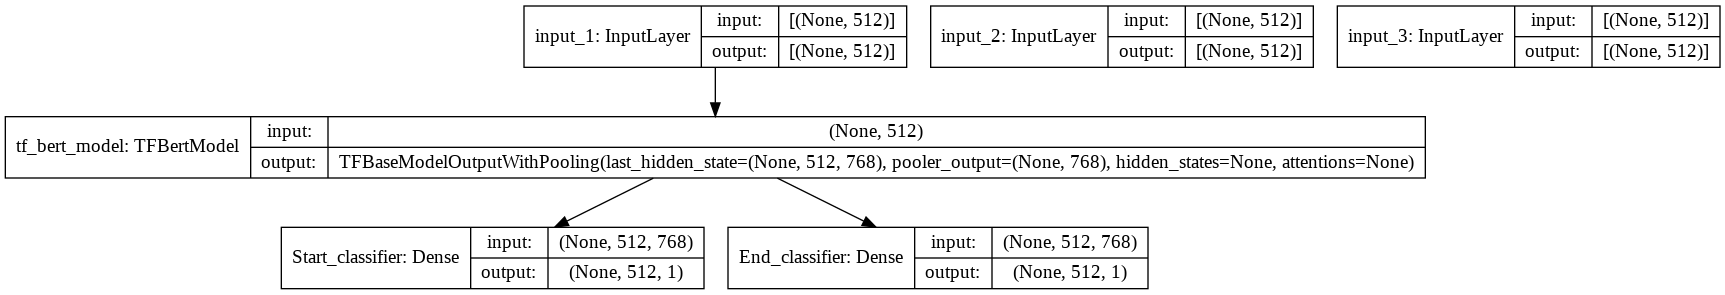

In [21]:
@tf.autograph.experimental.do_not_convert
def build_model():
  output_dim = SEQUENCE_LIMIT # add one class for non-found answers

  input_ids_layer = Input(shape = (512,), dtype='int64')
  attention_mask_layer = Input(shape = (512,), dtype='int64')
  token_ids_layer = Input(shape = (512,), dtype='int64')

  bert_model = TFBertModel.from_pretrained('bert-base-uncased')
  
  for layer in bert_model.layers:
    layer.trainable = False
  
  bert = bert_model(input_ids = input_ids_layer,
                    attention_mask = attention_mask_layer,
                    token_type_ids = token_ids_layer,
                    return_dict = False,
                    output_attentions = False,
                    output_hidden_states = False
                    ).last_hidden_state
  
  # flat = Flatten()(bert)
  start_classifier = Dense(units=1, activation="softmax", name="Start_classifier")(bert)
  end_classifier = Dense(units=1, activation="softmax", name="End_classifier")(bert)

  model = Model(inputs=[input_ids_layer, attention_mask_layer, token_ids_layer], 
                outputs=[start_classifier, end_classifier])
  model.summary()
  return model


model = build_model()
plot_model(model, show_shapes=True)

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.CategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train

In [ ]:
EPOCHS = 3
BATCH_SIZE = 32

model_fit = model.fit(x = [train_inputs['input_ids'][:TRAIN_LIMIT],
                           train_inputs['attention_mask'][:TRAIN_LIMIT],
                           train_inputs['token_type_ids'][:TRAIN_LIMIT]],
                      y = [y_train_starts[:TRAIN_LIMIT], y_train_ends[:TRAIN_LIMIT]],
                       
                      batch_size=BATCH_SIZE, epochs=EPOCHS, 
                      validation_data=([test_inputs['input_ids'][:TEST_LIMIT],
                                        test_inputs['attention_mask'][:TEST_LIMIT],
                                        test_inputs['token_type_ids'][:TEST_LIMIT]], 
                                       [y_test_starts[:TEST_LIMIT],
                                         y_test_ends[:TEST_LIMIT]]
                                       )
)

Epoch 1/3
188/188 [==============================] - 334s 2s/step - loss: 12.4767 - Start_classifier_loss: 6.2383 - End_classifier_loss: 6.2383 - Start_classifier_accuracy: 6.1021e-04 - End_classifier_accuracy: 6.1021e-04 - val_loss: 12.4767 - val_Start_classifier_loss: 6.2383 - val_End_classifier_loss: 6.2383 - val_Start_classifier_accuracy: 0.0080 - val_End_classifier_accuracy: 0.0080
Epoch 2/3
188/188 [==============================] - ETA: 0s - loss: 12.4767 - Start_classifier_loss: 6.2383 - End_classifier_loss: 6.2383 - Start_classifier_accuracy: 8.9823e-04 - End_classifier_accuracy: 8.9823e-04

# Test

In [ ]:
TEST_LIMIT = len(test_inputs)

start_pred, end_pred = model.predict([test_inputs["input_ids"][:TEST_LIMIT], 
                                      test_inputs["attention_mask"][:TEST_LIMIT], 
                                      test_inputs["token_type_ids"][:TEST_LIMIT]])
start_pred = np.argmax(start_pred, axis=1)
end_pred = np.argmax(end_pred, axis=1)


def get_text_from_token_ids(context, start_id, end_id):
  return tokenizer.decode(context[start_id:end_id])



boom_baby = 0
for i, row in test_df.iterrows():
  if i == TEST_LIMIT: break
  true_answer = row["answer_text"]
  predicted_answer = get_text_from_token_ids(test_inputs["input_ids"][i-1], start_pred[i-1], end_pred[i-1])

  if true_answer == predicted_answer:
    boom_baby += 1

  if i % 1000 == 0:
    print("\n\nQuestion: \n", row["question_text"])
    print("Context: \n", test_context_dict[row["context_id"]])
    print("Answer text: \n", true_answer)
    print(f"Our answer: \n\tids {(start_pred[i-1], end_pred[i-1])}\n\ttext: {predicted_answer}")
    print("-"*50)

In [ ]:
print(f"Total matches\t{boom_baby} / {TEST_LIMIT} \t({round(boom_baby / TEST_LIMIT, 3)*100} %)")

In [ ]:
with open("results_2101_start_pred.txt", "w") as f:
  f.write(start_pred)

with open("results_2101_end_pred.txt", "w") as f:
  f.write(end_pred)